# PNEUMONIA DETECTION CHALLENGE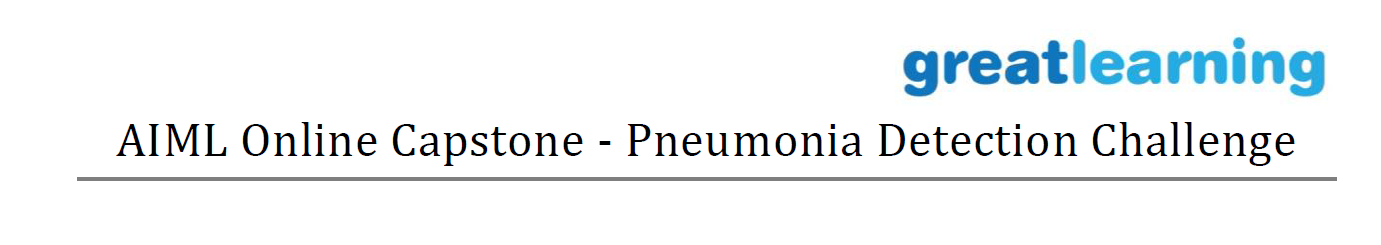

## The Real Problem
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli.
Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017, 920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis.
CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift.
## Pneumonia Detection
Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

## Business Domain 
Value Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

## Project Description
In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.
In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.
Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## Install Necessary Dependencies

In [ ]:
!pip install pydicom tqdm

     |████████████████████████████████| 2.0 MB 9.5 MB/s 


In [ ]:
import numpy as np
import cv2
import pydicom as dicom
from skimage import exposure
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as patches
from  PIL import Image, ImageDraw
from skimage import io
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import pydicom


#Mount Google drive for dataset preparation, model training and Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_subdir = "Capstone GL AIML/capstone project"

In [ ]:
import os
os.chdir(f'/content/drive/MyDrive/{drive_subdir}')

In [ ]:
# from zipfile import ZipFile

# with ZipFile('/content/drive/MyDrive/Capstone GL AIML/rsna-pneumonia-detection-challenge.zip') as zf:
#     zf.extractall(path = f"/content/drive/MyDrive/{drive_subdir}")

## Exploratory Data Analysis on the Dataset

In [ ]:
train_labels= pd.read_csv(f"/content/drive/MyDrive/{drive_subdir}/stage_2_train_labels.csv/stage_2_train_labels.csv")
class_labels = pd.read_csv(f"/content/drive/MyDrive/{drive_subdir}/stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv")

In [ ]:
images_path = f"/content/drive/MyDrive/{drive_subdir}/stage_2_train_images/"

The following code was used to extract patient data from the dicom files, data such as image view position, patient age and sex.

In [ ]:
print(train_labels.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [ ]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
print('The train_label dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))

The train_label dataframe has 30227 rows and 6 columns.


In [ ]:
# Number of duplicates in patientId:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

Number of unique patientId are: 26684


In [ ]:
train_labels[train_labels.isnull().any(axis=1)].Target.value_counts() #the null column values are with Target 0 indicating that those patients do not have penumonia

0    20672
Name: Target, dtype: int64

In [ ]:
train_labels[~train_labels.isnull().any(axis=1)].Target.value_counts() ## all the non null column values are with Target 1 indicating that those patients have pneumonia

1    9555
Name: Target, dtype: int64

In [ ]:
train_labels.Target.value_counts()  ##there are 20672 records with no pneumonia and 9555 with pneumonia

0    20672
1     9555
Name: Target, dtype: int64

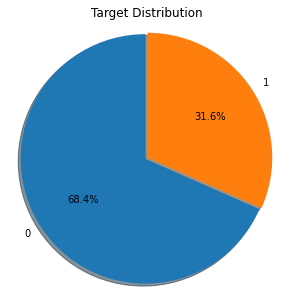

In [ ]:
label_count=train_labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

* there are 31% of patients with pneumonia and the remaining are no pneumonia
*There is a class imbalance issue

In [ ]:
duplicateRDF = train_labels[train_labels.duplicated(['patientId'])]
duplicateRDF.shape

(3543, 6)

There are 3543 duplicates

## Visualising the details of the DCM file

In [ ]:
import pydicom

patientId = train_labels['patientId'][0]
dcm_file = f'/content/drive/MyDrive/{drive_subdir}/stage_2_train_images/{patientId}.dcm'
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
img = dcm_data.pixel_array
print(type(img))
print(img.dtype)
print(img.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


In [ ]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
class_labels.shape

(30227, 2)

In [ ]:
class_labels.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [ ]:
print('Size of Dataset 1: ',train_labels.shape)
print('Size of Dataset 2: ',class_labels.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',class_labels['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (30227, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


In [ ]:
duplicateClassRDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRDF.shape

(3543, 2)

There are 3543 duplicates similar to the train_labels dataset

## Merged dataframe showing the class labels and the patient details with bounding box details

The data set was merged with the following code and stored in a new csv file. This file also contains patient data extracted from dicom files.

In [ ]:
merged = pd.merge(left = train_labels, right = class_labels, how = 'left', on = 'patientId') # Merge
## merged = merged.drop_duplicates() # Remove duplicates
merged.head(10)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
7,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
8,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


Text(0.5, 1.0, 'Class and Target  Distribution')

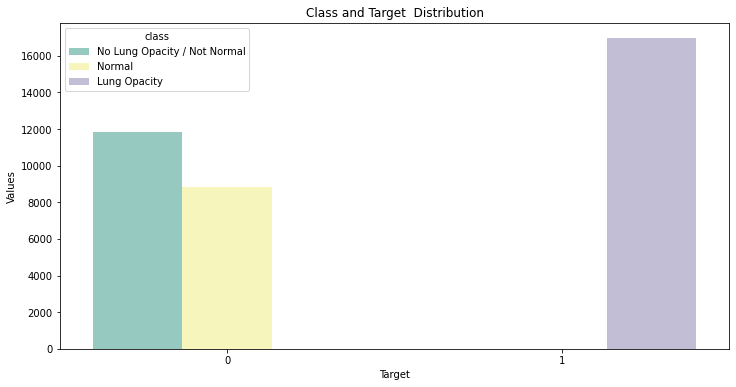

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = merged.groupby('Target')['class'].value_counts()
target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = target_class, palette = 'Set3')
plt.title('Class and Target  Distribution')


1. Target 0 has only Normal or No Lung Opacity class
2. Target 1 has only Lung Opacity class

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AllPatientData.csv to AllPatientData (10).csv


In [ ]:
final = pd.read_csv("AllPatientData.csv")

In [ ]:
final.head(10)

,Unnamed: 0,patientId,class,x,y,width,height,Target,ViewPosition,Age,Sex
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,PA,51,F
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,PA,48,F
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,AP,19,M
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,PA,28,M
4,4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,AP,32,F
5,5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1,AP,32,F
6,6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,AP,54,M
7,7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,PA,78,M
8,8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,323.0,577.0,160.0,104.0,1,PA,75,M
9,9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,695.0,575.0,162.0,137.0,1,PA,75,M


In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    30227 non-null  int64  
 1   patientId     30227 non-null  object 
 2   class         30227 non-null  object 
 3   x             9555 non-null   float64
 4   y             9555 non-null   float64
 5   width         9555 non-null   float64
 6   height        9555 non-null   float64
 7   Target        30227 non-null  int64  
 8   ViewPosition  30227 non-null  object 
 9   Age           30227 non-null  int64  
 10  Sex           30227 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.5+ MB


In [ ]:
final.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,30227.0,NaN,NaN,NaN,15113.0,8725.92763,0.0,7556.5,15113.0,22669.5,30226.0
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
ViewPosition,30227,2,AP,15297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,30227.0,NaN,NaN,NaN,46.797764,16.89294,1.0,34.0,49.0,59.0,155.0


In [ ]:
final['class'].value_counts(dropna=False)

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
final.patientId.nunique()

26684

In [ ]:
final[(final['class']=='No Lung Opacity / Not Normal')|(final['class']=='Normal')].shape

(20672, 11)

In [ ]:
final[(final['class']=='No Lung Opacity / Not Normal')|(final['class']=='Normal')].patientId.nunique()

20672

In [ ]:
final[(final['class']=='Lung Opacity')].patientId.nunique()


6012

In [ ]:
final[(final['class']=='Lung Opacity')].groupby('patientId').size().value_counts()


2    3266
1    2614
3     119
4      13
dtype: int64

In [ ]:
final.Sex.value_counts()

M    17216
F    13011
Name: Sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

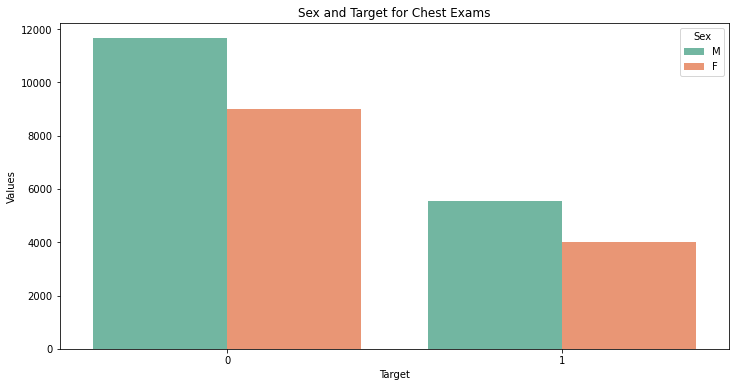

In [ ]:
## Distribution of Sex Among the targets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = final.groupby('Target')['Sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'Sex', data = data_target_class, palette = 'Set2')
plt.title('Sex and Target for Chest Exams')

**** Numbers of males in both category are higher than women**

Text(0.5, 1.0, 'Sex and class for Chest Exam')

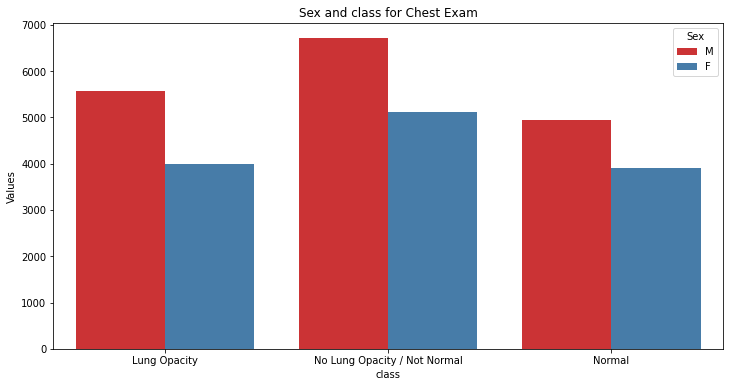

In [ ]:
## Distribution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = final.groupby('class')['Sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'Sex', data = data_target_class, palette = 'Set1')
plt.title('Sex and class for Chest Exam')

**Numbers of males in all classes are higher than women**

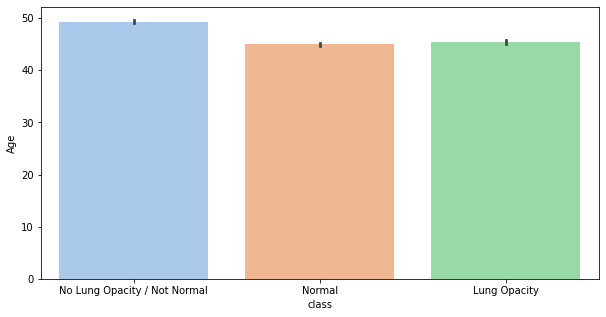

In [ ]:
#Distribution of Age with class

plt.figure(figsize=(10,5))  
ax = sns.barplot(x='class', y='Age', data=final, palette='pastel')


**Maximum age of person with pneuomina is around 45**




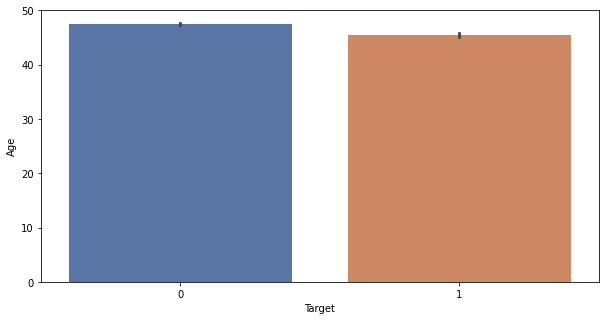

In [ ]:
## Distubution of Age with class

plt.figure(figsize=(10,5))  
ax = sns.barplot(x='Target', y='Age', data= final, palette='deep')  # barplot'


**Maximum age of person with pneuomina is around 45**

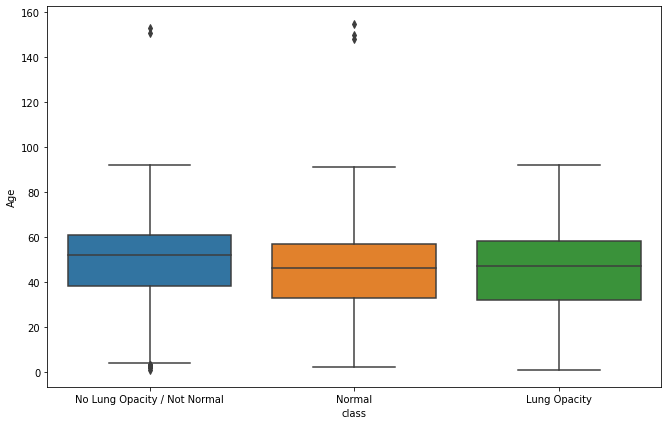

In [ ]:


plt.figure(figsize=(11,7))
sns.boxplot(x='class', y='Age', data= final)
plt.show()

 1. class which has no pneuomia has few outliers
 2. Age is around 150 which is typo error

In [ ]:
pd.pivot_table(final,index=["Target"], values=['patientId'], aggfunc='count')

,patientId
Target,
0,20672
1,9555


In [ ]:
final.groupby('patientId').Target.mean().value_counts()

0.0    20672
1.0     6012
Name: Target, dtype: int64

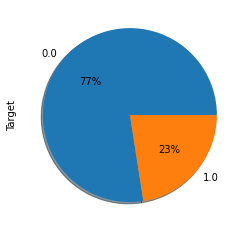

In [ ]:
final.groupby('patientId').Target.mean().value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)

In [ ]:
pd.pivot_table(final,index=["class"], values=['patientId'], aggfunc='count')

,patientId
class,
Lung Opacity,9555
No Lung Opacity / Not Normal,11821
Normal,8851


## Distribution of Patient IDs based on classes labels defined.
### We have 3 classes in total with 'No Lung Opacity/Not Normal' classified as non-pneumonia cases. We need to understand whether some cases are actually mis classified here

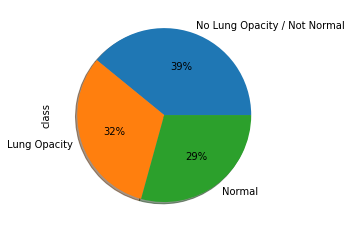

In [ ]:
final["class"].value_counts().plot(kind='pie',autopct='%1.0f%%', shadow=True, subplots=False)

In [ ]:
pd.pivot_table(final,index=["Target"], aggfunc='count')

,Age,Sex,Unnamed: 0,ViewPosition,class,height,patientId,width,x,y
Target,,,,,,,,,,
0,20672,20672,20672,20672,20672,0,20672,0,0,0
1,9555,9555,9555,9555,9555,9555,9555,9555,9555,9555


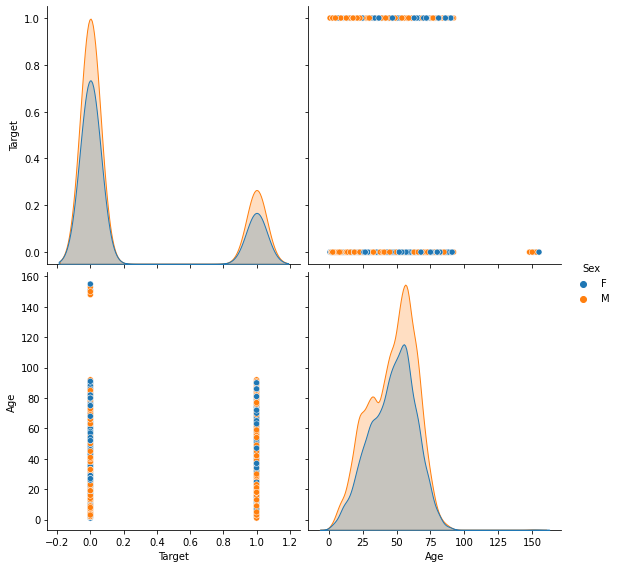

In [ ]:
import seaborn as sns
sns.pairplot(final.drop_duplicates(subset = 'patientId'), vars=['Target', 'Age'], hue='Sex', height=4)

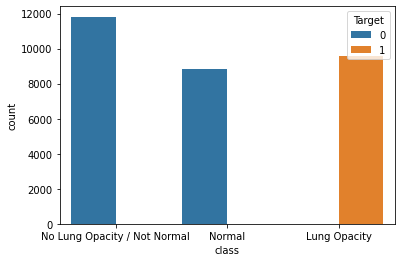

In [ ]:
sns.countplot(x = 'class', hue = 'Target', data = final)

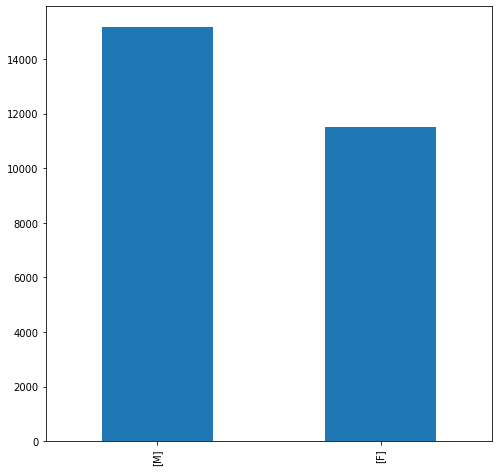

In [ ]:
plt.figure(figsize=(8,8))
final.groupby('patientId').Sex.unique().value_counts().plot(kind='bar')

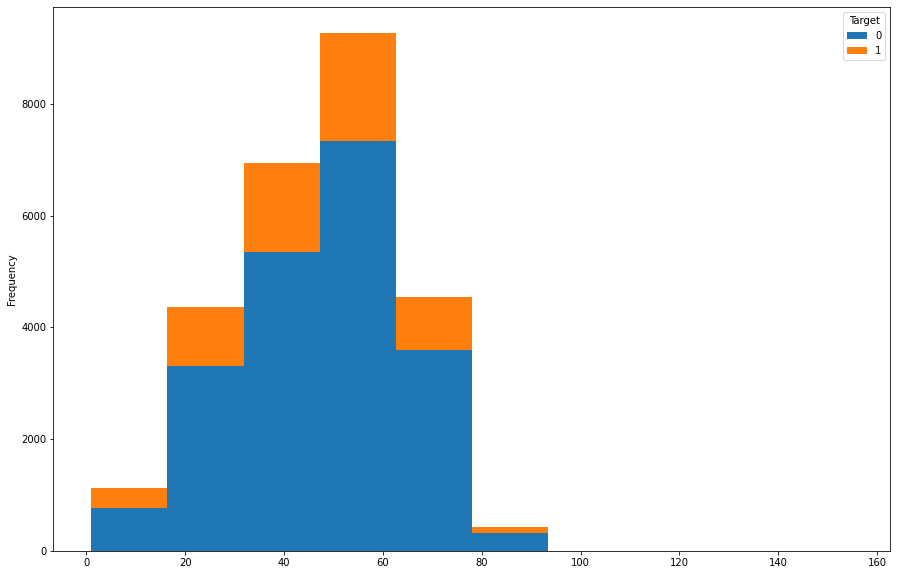

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
final.groupby(['patientId', 'Target']).Age.mean(['unique']).unstack().plot(kind='hist', stacked=True, ax=ax)

Relation between bounding boxes and view position of image

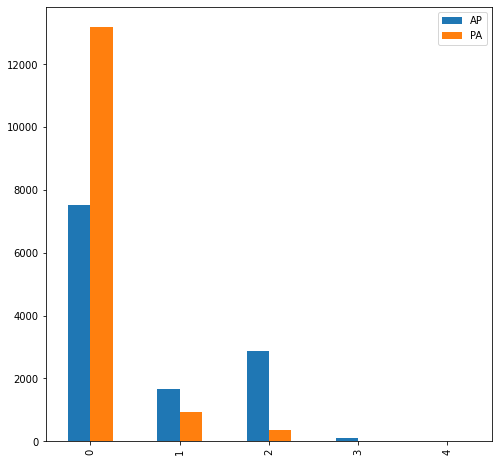

In [ ]:
AP = pd.Series(name = 'AP', data=final.groupby(['patientId', 'ViewPosition']).size().unstack(fill_value=0).value_counts().unstack().iloc[:,0])
PA = pd.Series(name = 'PA', data=final.groupby(['patientId', 'ViewPosition']).size().unstack(fill_value=0).value_counts().unstack().iloc[0,:])
PA[0] = final[final.Target==0].drop_duplicates(subset='patientId').ViewPosition.value_counts()[0]
AP[0] = final[final.Target==0].drop_duplicates(subset='patientId').ViewPosition.value_counts()[1]
PA[1] = PA[1]-PA[0]
AP[1] = AP[1]-AP[0]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
APPA = pd.DataFrame([AP, PA]).T
APPA.plot(kind='bar', ax = ax)

In [ ]:
APPA

,AP,PA
0,7509.0,13163.0
1,1664.0,950.0
2,2888.0,378.0
3,100.0,19.0
4,12.0,1.0


Number of patients with respect to number of bounding boxes

In [ ]:
APPA.sum(axis=1)

0    20672.0
1     2614.0
2     3266.0
3      119.0
4       13.0
dtype: float64

In [ ]:
def get_feature_distribution(data, feature):
  # Count for each label
  label_counts = data[feature].value_counts()
  # Count the number of items in each class
  total_samples = len(data)
  print("Feature: {}".format(feature))
  for i in range(len(label_counts)):
    label = label_counts.index[i]
    count = label_counts.values[i]
    percent = int((count / total_samples) * 10000) / 100
    print("{:<30s}: {} which is {}% of the total data in the dataset".format(label, count, percent))

In [ ]:
import warnings
warnings.filterwarnings('ignore')


get_feature_distribution(final.drop_duplicates('patientId'), 'ViewPosition')

Feature: ViewPosition
PA                            : 14511 which is 54.38% of the total data in the dataset
AP                            : 12173 which is 45.61% of the total data in the dataset


The distribution of View Position with evidence of Pneumonia:



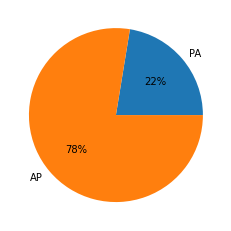

In [ ]:
print('The distribution of View Position with evidence of Pneumonia:\n')
_ = final.drop_duplicates('patientId').loc[final['Target'] == 1, 'ViewPosition'].value_counts().sort_index(ascending = False).plot(kind = 'pie', autopct = '%.0f%%').set_ylabel('')

## Creating a correlation plot to understand  

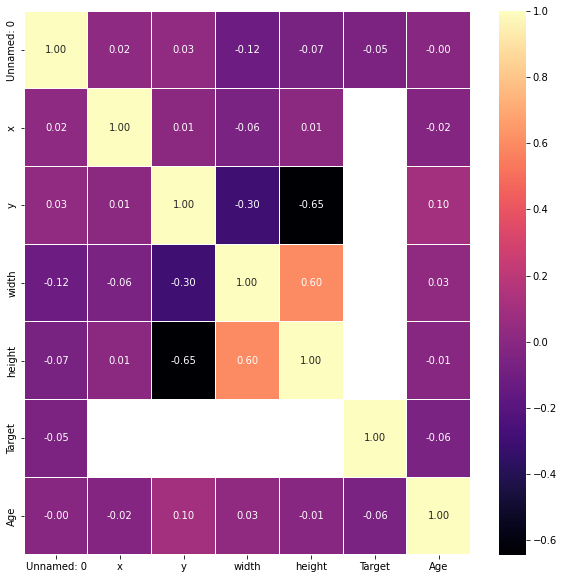

In [ ]:
fig,ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(final.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma") 
plt.show()

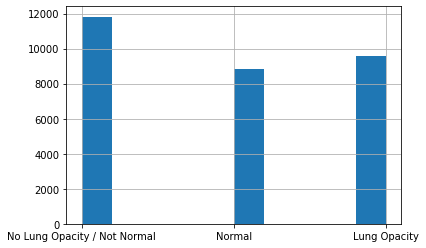

In [ ]:
# Look at the amounts in each of the different classes
final['class'].hist();

26,684 unique patients.<br>
20,672 unique patients that are Normal / Not Normal / No Lung Opacity.<br>
6012 unique patients that have Lung Opacity.<br>

Data available on upto 4 bounding boxes per patient.

In [ ]:
import os

train_labels_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

k = 0
for i in range(len(train_labels)):
    if train_labels.loc[i]['Target'] == 1:
        train_labels_pos.loc[k] = train_labels.loc[i]
        k += 1

print('Positive instances dataframe shape:', train_labels_pos.shape)
train_paths = [os.path.join(images_path, image[0]) for image in train_labels_pos.values]

Positive instances dataframe shape: (9555, 5)


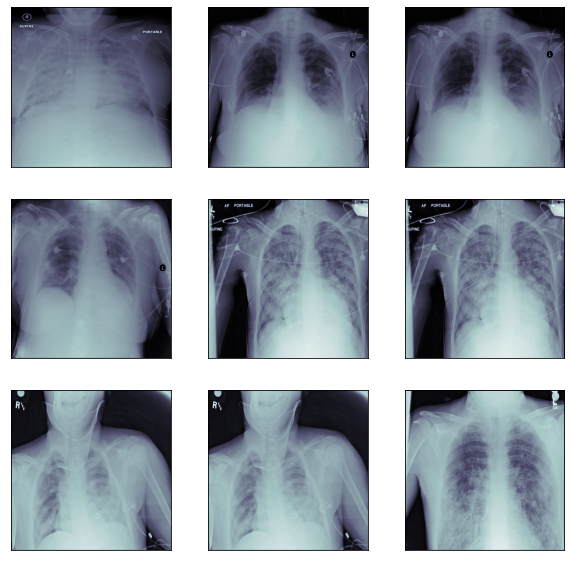

In [ ]:
from pydicom import dcmread

def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap='bone')

imshow()


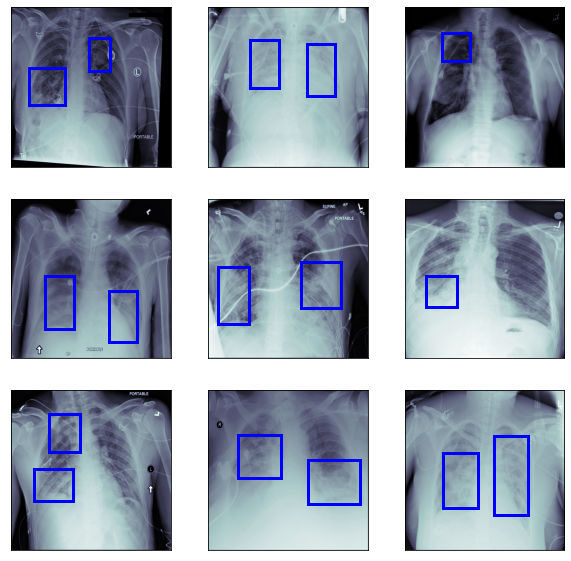

In [ ]:
def show_image_with_bboxes(num_to_show=9):
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        id_= np.random.choice(train_labels_pos['patientId'].values)

        current_axis = plt.gca()
        img=pydicom.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
        plt.imshow(img,cmap='bone')


        current_axis = plt.gca()
        boxes=train_labels_pos[['x','y','width','height']][train_labels_pos['patientId']==id_].values

        for box in boxes:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            current_axis.add_patch(plt.Rectangle((x, y), w, h, color='blue', fill=False, linewidth=3)) 
        
show_image_with_bboxes()

<Figure size 432x288 with 0 Axes>

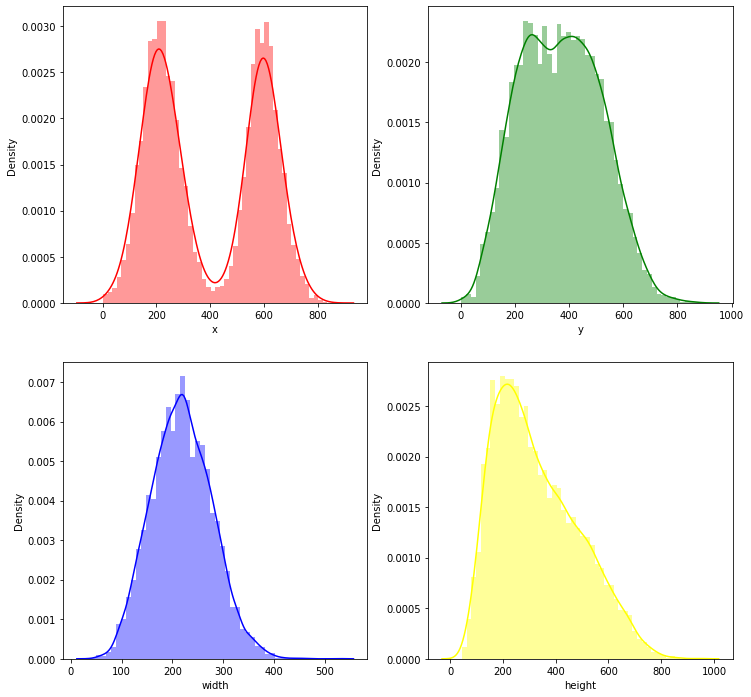

In [ ]:
target1 = train_labels[train_labels['Target']==1]
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="green", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="blue", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="yellow", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both')
plt.show()

In [ ]:
sample_data = final.groupby('class', group_keys=False).apply(lambda x: x.sample(1000))

In [ ]:
sample_data["class"].value_counts()

Lung Opacity                    1000
No Lung Opacity / Not Normal    1000
Normal                          1000
Name: class, dtype: int64

In [ ]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 12898 to 3161
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    3000 non-null   int64  
 1   patientId     3000 non-null   object 
 2   class         3000 non-null   object 
 3   x             1000 non-null   float64
 4   y             1000 non-null   float64
 5   width         1000 non-null   float64
 6   height        1000 non-null   float64
 7   Target        3000 non-null   int64  
 8   ViewPosition  3000 non-null   object 
 9   Age           3000 non-null   int64  
 10  Sex           3000 non-null   object 
dtypes: float64(4), int64(3), object(4)
memory usage: 281.2+ KB


In [ ]:
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import cv2

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

import math

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
import pydicom as dcm

images = []
ADJUSTED_IMAGE_SIZE = 224
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = f'/content/drive/MyDrive/{drive_subdir}/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array

        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [ ]:
images,labels = populateImage(sample_data)

In [ ]:
images.shape , labels.shape

((3000, 224, 224, 3), (3000,))

The image is of 224*224 with 3 channels 

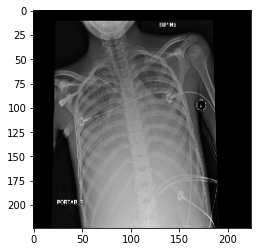

In [ ]:
plt.imshow(images[120])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [ ]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.2, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.2, random_state=50)

In [ ]:
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [ ]:
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization

cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
## Training for 30 epocs with batch size of 30
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 10,
                  validation_data = (X_val,y_val),
                  batch_size = 50)

Epoch 1/10
48/48 [==============================] - 394s 8s/step - loss: 3.0264 - accuracy: 0.3483 - val_loss: 1.0828 - val_accuracy: 0.4722
Epoch 2/10
48/48 [==============================] - 388s 8s/step - loss: 1.1074 - accuracy: 0.3683 - val_loss: 1.2429 - val_accuracy: 0.3444
Epoch 3/10
48/48 [==============================] - 391s 8s/step - loss: 1.1287 - accuracy: 0.3404 - val_loss: 1.0885 - val_accuracy: 0.4500
Epoch 4/10
48/48 [==============================] - 388s 8s/step - loss: 1.1325 - accuracy: 0.3717 - val_loss: 1.0834 - val_accuracy: 0.4389
Epoch 5/10
48/48 [==============================] - 392s 8s/step - loss: 1.0772 - accuracy: 0.4117 - val_loss: 1.0834 - val_accuracy: 0.3833
Epoch 6/10
48/48 [==============================] - 389s 8s/step - loss: 1.0649 - accuracy: 0.4425 - val_loss: 1.0416 - val_accuracy: 0.5000
Epoch 7/10
48/48 [==============================] - 390s 8s/step - loss: 1.0634 - accuracy: 0.4433 - val_loss: 1.0616 - val_accuracy: 0.4889
Epoch 8/10
48

In [ ]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

14/14 [==============================] - 16s 1s/step - loss: 1.0705 - accuracy: 0.4190
Test loss: 1.0704529285430908
Test accuracy: 0.41904762387275696


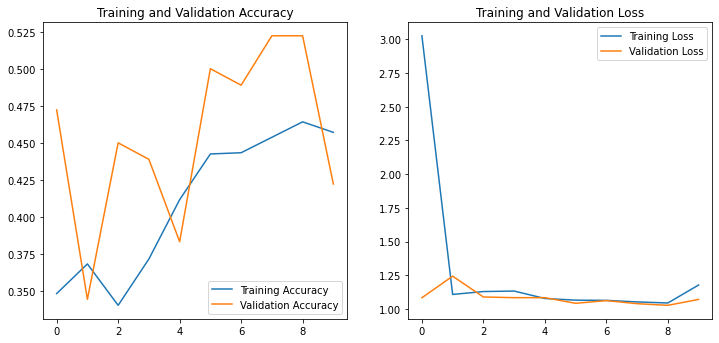

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

In [ ]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 50)                1254450   
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 3)                 63        
                                                                 
Total params: 15,970,221
Trainable params: 1,255,533
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Early stopping whe validation accuracy does not change for 5 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5,  restore_best_weights=True)

#Trainign the model
history = VGG16_model.fit(train_ds, y_train, epochs=10, validation_data=(train_val_df,y_val) ,callbacks=es)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 1126s 15s/step - loss: 1.5235 - accuracy: 0.5967 - val_loss: 0.7269 - val_accuracy: 0.6750
Epoch 2/10
75/75 [==============================] - 1107s 15s/step - loss: 0.4382 - accuracy: 0.7825 - val_loss: 0.6757 - val_accuracy: 0.7167
Epoch 3/10
75/75 [==============================] - 1109s 15s/step - loss: 0.2290 - accuracy: 0.8767 - val_loss: 0.6831 - val_accuracy: 0.6917
Epoch 4/10
75/75 [==============================] - 1102s 15s/step - loss: 0.1176 - accuracy: 0.9558 - val_loss: 0.7088 - val_accuracy: 0.7167
Epoch 5/10
75/75 [==============================] - 1101s 15s/step - loss: 0.0515 - accuracy: 0.9879 - val_loss: 0.7529 - val_accuracy: 0.7083
Epoch 6/10
75/75 [==============================] - 1101s 15s/step - loss: 0.0256 - accuracy: 0.9971 - val_loss: 0.7291 - val_accuracy: 0.6833
Epoch 7/10
75/75 [==============================] - 1101s 15s/step - loss: 0.0129 - accuracy: 0.9996 - val_loss: 0.7603 - val_accuracy: 0.7417
Epoch 8/10

In [ ]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


15/15 [==============================] - 254s 16s/step - loss: 1.0614 - accuracy: 0.6687
Test loss: 1.061407446861267
Test accuracy: 0.668749988079071


1.The Test accuracy score is 68% but the training accuracy is 100%.

2.This model is overfit

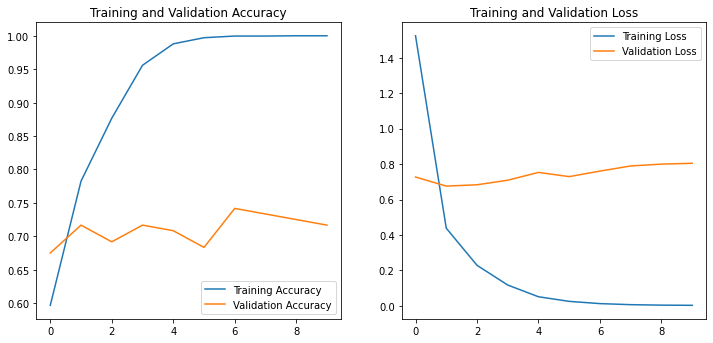

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()